According to the data (See [1516.sql](./1516.sql))
Kevin Durant is moved to the injury list on 2016-01-04 against the Kings. 

However after referencing the [game data](https://www.basketball-reference.com/boxscores/pbp/201601040OKC.html), he did not play in that game. 
This means that he was injured the game prior 
[2016-01-02 against the Hornets](https://www.basketball-reference.com/boxscores/pbp/201601020CHO.html).

This Checks out as he see find this [clip](https://www.youtube.com/watch?v=MAe4-UCt1Dg&t=48s) of the injury happening at at around Q2 3:30 from game highlighs. Here's the PbP data for that.

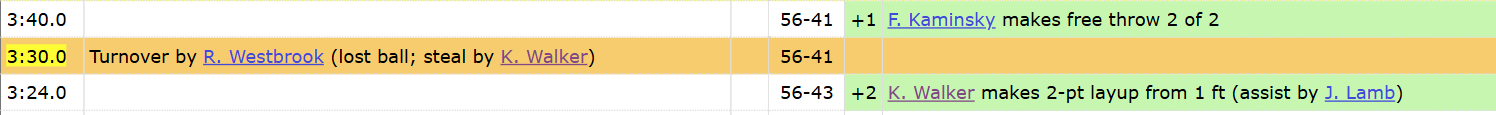

These "articles" reference the injury happening during this game as well:
[ESPN](https://www.espn.com/nba/story/_/id/14501718/kevin-durant-oklahoma-city-thunder-vs-sacramento-kings), 
[Sportsnet](https://www.sportsnet.ca/basketball/nba/mri-on-bulls-point-guard-rose-shows-no-structural-damage/)

Why is this important?
We have access to GPS data for the 2015-2016 seaons. This is around 25 FPS of positioning data. Let's try to pinpoint this moment of the game, and see KD's coordinates to track speed, abrupt movements, etc.



In [14]:
# Imports
from nba_api.stats.static import players
from nba_api.stats.endpoints import (
    PlayerGameLog,
    BoxScoreTraditionalV2,
    BoxScoreAdvancedV2,
    DraftCombinePlayerAnthro,
    CommonPlayerInfo
)
import pandas as pd
from pandasql import sqldf

In [16]:
pid = players.find_players_by_full_name("Kevin Durant")[0]["id"]

logs = PlayerGameLog(
    player_id=pid,
    season="2015-16",
    season_type_all_star="Regular Season"
).get_data_frames()[0]

game = logs[logs["MATCHUP"].str.contains("CHA")]

#### Game Info: 

January 2nd 2016, OKC Thunder vs. Charlotte Hornets @ Charlotte

Gmae_ID: 0021500497

[Basketball Reference Link](https://www.basketball-reference.com/boxscores/pbp/201601020CHO.html)
game

PBP ID: 201601020CHO

Plyaer: Kevin Durant (201142)

Injury Time: Q2 ~3:33 - 3:28
See [This Video](https://youtube.com/clip/UgkxKiam06M4QdCHjjBRtAE22kwRH0qkH4y3?si=kuB9lsCAHIwV8q-I)



Below, we will try and calculate some metrics like speed, velocity (speed with direction), and apossibly acceleration of KD during his injury. See what insights we can get. To see prep work for this data check [This csv](./data/201601020CHO/x_loc,y_loc,game_clock.csv), and [path.sql](./Path.sql).

<p><img src="./Kd_injury.png" width="300" alt="KD injury" /></p>

In [12]:
injury = pd.read_csv("./data/201601020CHO/x_loc,y_loc,game_clock.csv")

In [11]:
injury.head()   

,x_loc,y_loc,game_clock
0,47.23342,22.79412,215.12
1,47.74557,22.79995,215.08
2,48.25491,22.81623,215.04
3,48.75800,22.83103,215.00
4,49.25918,22.85072,214.96


In [26]:
df = pd.read_csv("./data/201601020CHO/x_loc,y_loc,game_clock.csv")

# Sort so time increases
df = df.sort_values("game_clock", ascending=True).reset_index(drop=True)

# Differences
df["dx"] = df["x_loc"].diff()
df["dy"] = df["y_loc"].diff()
df["dt"] = df["game_clock"].diff().abs()

# Velocity (vx, vy)
df["vx"] = df["dx"] / df["dt"]
df["vy"] = df["dy"] / df["dt"]

# Speed (scalar)
df["speed"] = (df["vx"]**2 + df["vy"]**2)**0.5

print(df.head(10))

      x_loc     y_loc  game_clock       dx       dy    dt        vx       vy  \
0  66.64418  31.52703      209.92      NaN      NaN   NaN       NaN      NaN   
1  66.83673  31.66143      209.96  0.19255  0.13440  0.04   4.81375  3.36000   
2  67.11424  31.78626      210.00  0.27751  0.12483  0.04   6.93775  3.12075   
3  67.46742  31.89910      210.04  0.35318  0.11284  0.04   8.82950  2.82100   
4  67.90253  32.00091      210.08  0.43511  0.10181  0.04  10.87775  2.54525   
5  68.32393  32.09702      210.12  0.42140  0.09611  0.04  10.53500  2.40275   
6  68.73615  32.18460      210.16  0.41222  0.08758  0.04  10.30550  2.18950   
7  69.12859  32.27200      210.20  0.39244  0.08740  0.04   9.81100  2.18500   
8  69.49908  32.33273      210.24  0.37049  0.06073  0.04   9.26225  1.51825   
9  69.86634  32.38408      210.28  0.36726  0.05135  0.04   9.18150  1.28375   

       speed  
0        NaN  
1   5.870416  
2   7.607329  
3   9.269202  
4  11.171560  
5  10.805528  
6  10.535523  

What we have created here is the player's instantaneous speed at each frame at the time of his injury.
With this we can train the model, so it can conduct if a player is at risk of injury based on their movement patterns.

However this may be infeasible as I had to manually map the time of injury to whatever clip I found of the game. There is no timestamped injury data.

However this SportsVU gps data can still prove to be useful because we can try and use speed, and sudden movement as a possible measurement of playing intensity. In many studies, it has been found that high intensity play whether in training or in game, is usually one of the top SHAP indicators for injury risk.